In [1]:
import os
from os import listdir
import json
from shutil import copyfile


In [2]:
import matplotlib.pyplot as plt
import numpy as np
import PIL
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
import pathlib

In [25]:
data_dir = "D:animals"

In [42]:
batch_size =32
#img_height = 180
#img_width = 180
img_height = 160
img_width = 160

In [43]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(data_dir, validation_split = 0.2, subset = "training",
                                                                 seed =123, image_size = (img_height, img_width),
                                                                 batch_size = batch_size)

Found 2764 files belonging to 3 classes.
Using 2212 files for training.


In [44]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(data_dir, validation_split = 0.2, subset = "validation",
                                                                 seed =123, image_size = (img_height, img_width),
                                                                 batch_size = batch_size)

Found 2764 files belonging to 3 classes.
Using 552 files for validation.


In [7]:
class_names = train_ds.class_names
print(class_names)

['bear', 'horse', 'zebra']


In [8]:
AUTOTUNE = tf.data.AUTOTUNE
train_ds= train_ds.cache().shuffle(1000).prefetch(buffer_size = AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size = AUTOTUNE)

In [9]:
normalization_layer = layers.experimental.preprocessing.Rescaling(1./255)

In [10]:
normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))

In [14]:
image_batch, labels_batch = next(iter(normalized_ds))

In [15]:
first_image = image_batch[0]
print(np.min(first_image), np.max(first_image))

0.0 0.8520021


In [16]:
num_classes = 3

In [17]:
model = Sequential([layers.experimental.preprocessing.Rescaling(1./255, input_shape = (img_height, img_width, 3)),
                    layers.Conv2D(16, 3, padding ='same', activation= 'relu'),
                    layers.MaxPooling2D(),
                    layers.Conv2D(32, 3, padding ='same', activation= 'relu'),
                    layers.MaxPooling2D(),
                    layers.Conv2D(64, 3, padding ='same', activation= 'relu'),
                    layers.MaxPooling2D(),
                    layers.Flatten(),
                    layers.Dense(128, activation ='relu'),
                    layers.Dense(num_classes)
                   ])

In [18]:
model.compile(optimizer = 'adam', 
              loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits =True),
              metrics = ['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_1 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 180, 180, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2  (None, 90, 90, 16)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 90, 90, 32)        4640      
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 45, 45, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 45, 45, 64)        1

In [28]:
history = model.fit(train_ds, validation_data = val_ds, epochs= 10)

Epoch 1/10
70/70 [==============================] - 33s 456ms/step - loss: 1.0037 - accuracy: 0.5086 - val_loss: 0.7875 - val_accuracy: 0.6594
Epoch 2/10
70/70 [==============================] - 29s 404ms/step - loss: 0.7148 - accuracy: 0.6826 - val_loss: 0.6855 - val_accuracy: 0.7083
Epoch 3/10
70/70 [==============================] - 28s 402ms/step - loss: 0.5797 - accuracy: 0.7608 - val_loss: 0.6354 - val_accuracy: 0.7337
Epoch 4/10
70/70 [==============================] - 28s 403ms/step - loss: 0.4606 - accuracy: 0.8151 - val_loss: 0.7523 - val_accuracy: 0.6902
Epoch 5/10
70/70 [==============================] - 29s 403ms/step - loss: 0.3415 - accuracy: 0.8730 - val_loss: 0.8510 - val_accuracy: 0.7283
Epoch 6/10
70/70 [==============================] - 28s 399ms/step - loss: 0.2730 - accuracy: 0.8915 - val_loss: 0.9078 - val_accuracy: 0.6975
Epoch 7/10
70/70 [==============================] - 29s 414ms/step - loss: 0.1622 - accuracy: 0.9471 - val_loss: 1.0374 - val_accuracy: 0.7083

In [29]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs_range = range(10)

Text(0.5, 1.0, 'Training and Validation Accuracy')

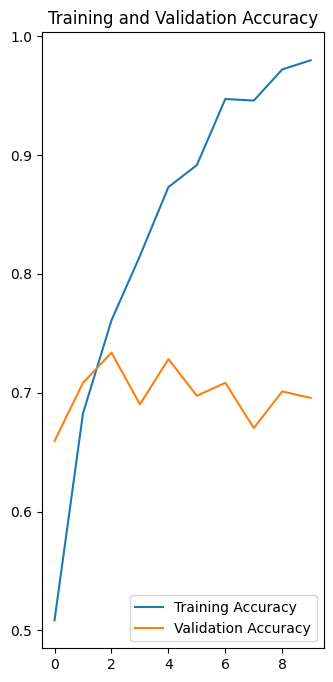

In [30]:
plt.figure(figsize = (8,8))
plt.subplot(1,2,1)
plt.plot(epochs_range, acc, label ='Training Accuracy')
plt.plot(epochs_range, val_acc, label ='Validation Accuracy')
plt.legend(loc ='lower right')
plt.title('Training and Validation Accuracy')

Text(0.5, 1.0, 'Training and Validation Loss')

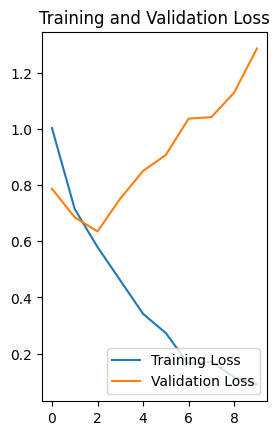

In [31]:
plt.subplot(1,2,1)
plt.plot(epochs_range, loss, label ='Training Loss')
plt.plot(epochs_range, val_loss, label ='Validation Loss')
plt.legend(loc ='lower right')
plt.title('Training and Validation Loss')

(32, 180, 180, 3)
(32,)


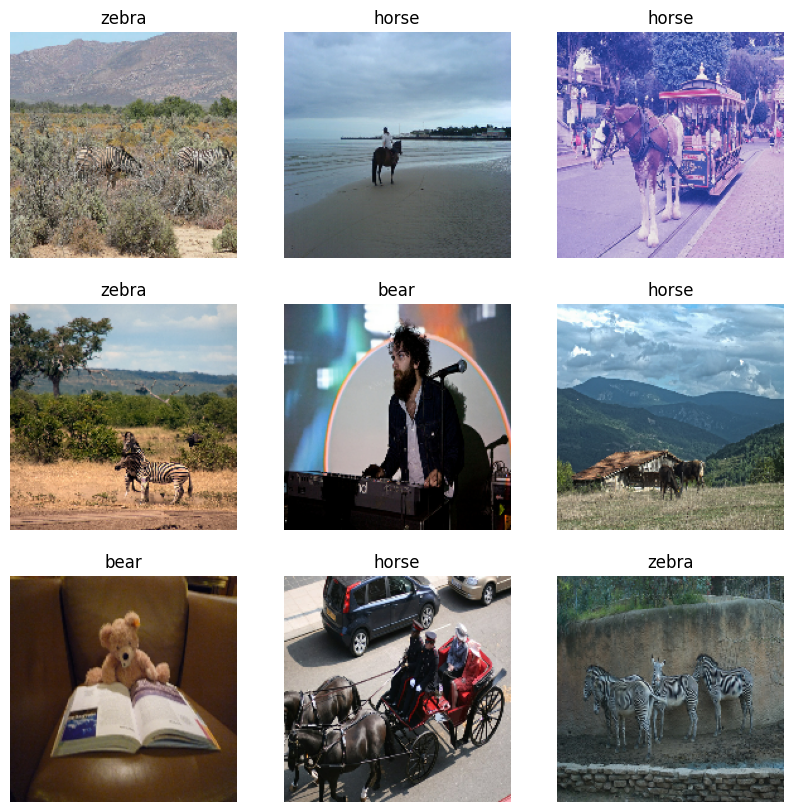

In [32]:
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")
for image_batch, labels_batch in train_ds:
    print(image_batch.shape)
    print(labels_batch.shape)
    break

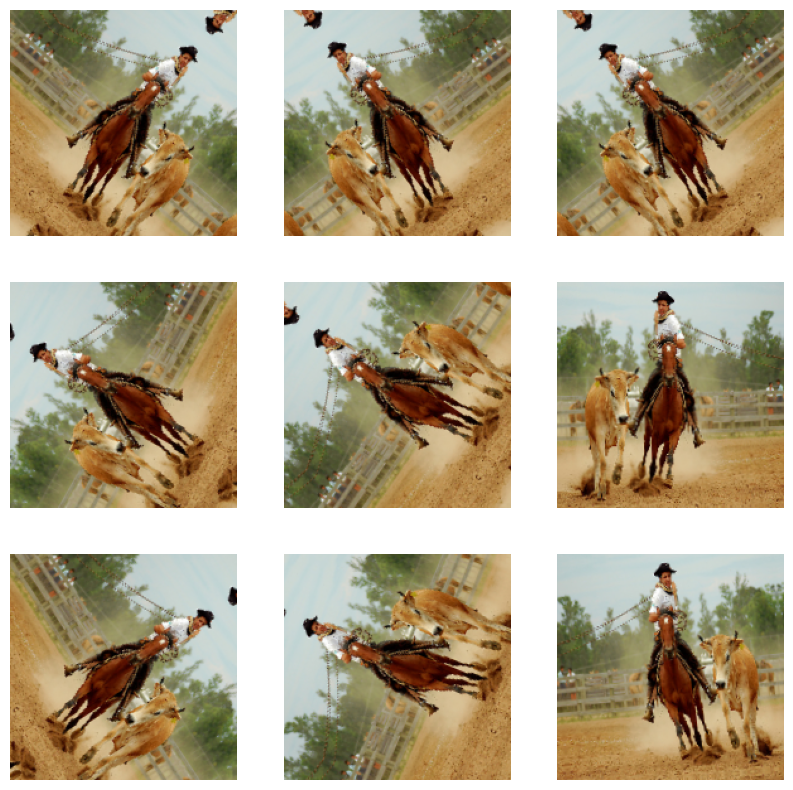

In [33]:
data_augmentation = tf.keras.Sequential([
tf.keras.layers.experimental.preprocessing.RandomFlip('horizontal'),
tf.keras.layers.experimental.preprocessing.RandomRotation(0.2),
])
for image, _ in train_ds.take(1):
    plt.figure(figsize=(10, 10))
    first_image = image[0]
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        augmented_image = data_augmentation(tf.expand_dims(first_image, 0))
        plt.imshow(augmented_image[0] / 255)
        plt.axis('off')

In [34]:
IMG_SIZE = (160, 160)
train_ds = tf.keras.preprocessing.image_dataset_from_directory(data_dir, validation_split = 0.2, subset = "training",
                                                                 seed =123, image_size = IMG_SIZE,
                                                                 batch_size = batch_size)
train_ds = tf.keras.preprocessing.image_dataset_from_directory(data_dir, validation_split = 0.2, subset = "training",
                                                                 seed =123, image_size = IMG_SIZE,
                                                                 batch_size = batch_size)

Found 2764 files belonging to 3 classes.
Using 2212 files for training.
Found 2764 files belonging to 3 classes.
Using 2212 files for training.


In [45]:
IMG_SHAPE = (160,160) + (3,)
base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,
include_top=False,
weights='imagenet')
image_batch, label_batch = next(iter(train_ds))
feature_batch = base_model(image_batch)
print(feature_batch.shape)

(32, 5, 5, 1280)


In [38]:
base_model.trainable = False
base_model.summary()
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average = global_average_layer(feature_batch)
print(feature_batch_average.shape)

Model: "mobilenetv2_1.00_160"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 160, 160, 3)]        0         []                            
                                                                                                  
 Conv1 (Conv2D)              (None, 80, 80, 32)           864       ['input_1[0][0]']             
                                                                                                  
 bn_Conv1 (BatchNormalizati  (None, 80, 80, 32)           128       ['Conv1[0][0]']               
 on)                                                                                              
                                                                                                  
 Conv1_relu (ReLU)           (None, 80, 80, 32)           0         ['bn_Conv1[

In [39]:
prediction_layer = tf.keras.layers.Dense(3)
prediction_batch = prediction_layer(feature_batch_average)
print(prediction_batch.shape)

(32, 3)


In [40]:
preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input

In [46]:
inputs = tf.keras.Input(shape=(160, 160, 3))
x = data_augmentation(inputs)
x = preprocess_input(x)
x = base_model(x, training=False)
x = global_average_layer(x)
x = tf.keras.layers.Dropout(0.2)(x)
outputs = prediction_layer(x)
model = tf.keras.Model(inputs, outputs)
base_learning_rate = 0.0001
model.compile(optimizer=tf.keras.optimizers.Adam(lr=base_learning_rate),
loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
metrics=['accuracy'])
model.summary()
len(model.trainable_variables)
initial_epochs = 10
loss0, accuracy0 = model.evaluate(val_ds)
print("initial loss: {:.2f}".format(loss0))
print("initial accuracy: {:.2f}".format(accuracy0))
history = model.fit(train_ds,
epochs=initial_epochs,
validation_data=val_ds)

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 160, 160, 3)]     0         
                                                                 
 sequential_1 (Sequential)   (None, None, None, 3)     0         
                                                                 
 tf.math.truediv_1 (TFOpLam  (None, 160, 160, 3)       0         
 bda)                                                            
                                                                 
 tf.math.subtract_1 (TFOpLa  (None, 160, 160, 3)       0         
 mbda)                                                           
                                                                 
 mobilenetv2_1.00_160 (Func  (None, 5, 5, 1280)        2257984   
 tional)                                                         
                                                           

In [48]:
base_model.trainable = True
base_model.summary()
# Let's take a look to see how many layers are in the base model
print("Number of layers in the base model: ", len(base_model.layers))
# Fine-tune from this layer onwards
fine_tune_at = 100
# Freeze all the layers before the `fine_tune_at` layer
for layer in base_model.layers[:fine_tune_at]:
    layer.trainable = False

Model: "mobilenetv2_1.00_160"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_3 (InputLayer)        [(None, 160, 160, 3)]        0         []                            
                                                                                                  
 Conv1 (Conv2D)              (None, 80, 80, 32)           864       ['input_3[0][0]']             
                                                                                                  
 bn_Conv1 (BatchNormalizati  (None, 80, 80, 32)           128       ['Conv1[0][0]']               
 on)                                                                                              
                                                                                                  
 Conv1_relu (ReLU)           (None, 80, 80, 32)           0         ['bn_Conv1[

In [49]:
model.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
optimizer = tf.keras.optimizers.RMSprop(lr=base_learning_rate/10),
metrics=['accuracy'])

In [50]:
fine_tune_epochs = 10
total_epochs = initial_epochs + fine_tune_epochs
history_fine = model.fit(train_ds,
epochs=total_epochs,
initial_epoch=history.epoch[-1],
validation_data=val_ds
)

Epoch 10/20
70/70 [==============================] - 22s 282ms/step - loss: 1.0995 - accuracy: 0.3752 - val_loss: 1.0832 - val_accuracy: 0.3768
Epoch 11/20
70/70 [==============================] - 18s 260ms/step - loss: 1.0893 - accuracy: 0.3797 - val_loss: 1.1405 - val_accuracy: 0.2482
Epoch 12/20
70/70 [==============================] - 18s 259ms/step - loss: 1.0948 - accuracy: 0.3807 - val_loss: 1.0846 - val_accuracy: 0.3768
Epoch 13/20
70/70 [==============================] - 18s 260ms/step - loss: 1.0940 - accuracy: 0.3599 - val_loss: 1.0986 - val_accuracy: 0.3750
Epoch 14/20
70/70 [==============================] - 18s 262ms/step - loss: 1.0930 - accuracy: 0.3734 - val_loss: 1.0938 - val_accuracy: 0.3750
Epoch 15/20
70/70 [==============================] - 20s 282ms/step - loss: 1.0952 - accuracy: 0.3671 - val_loss: 1.1136 - val_accuracy: 0.2482
Epoch 16/20
70/70 [==============================] - 20s 281ms/step - loss: 1.0963 - accuracy: 0.3599 - val_loss: 1.0918 - val_accuracy:

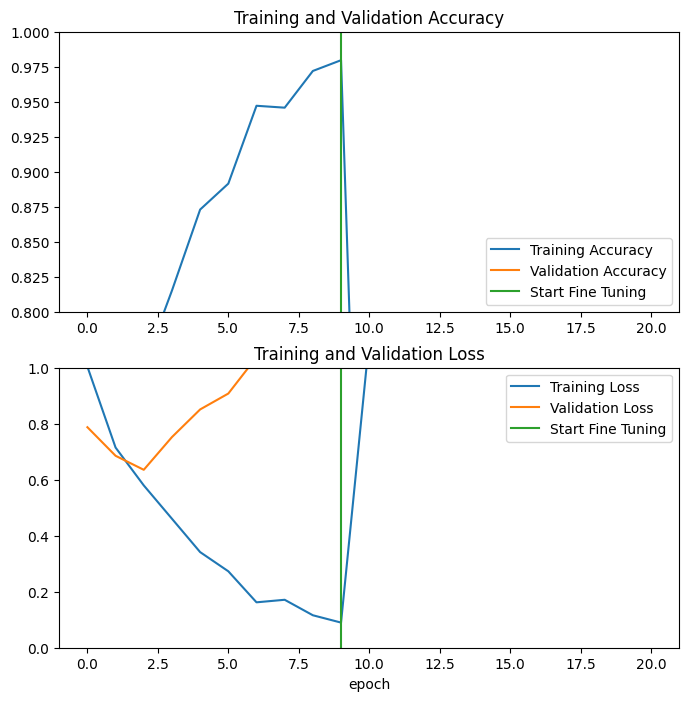

In [51]:
acc += history_fine.history['accuracy']
val_acc += history_fine.history['val_accuracy']
loss += history_fine.history['loss']
val_loss += history_fine.history['val_loss']
plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.ylim([0.8, 1])
plt.plot([initial_epochs-1,initial_epochs-1],
plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')
plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.ylim([0, 1.0])
plt.plot([initial_epochs-1,initial_epochs-1],
plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()